In [334]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from enum import Enum
import sys
import pandas as pd
import graphviz
from typing import Callable
from scipy.interpolate import lagrange
from sklearn.tree import DecisionTreeClassifier

### Name: Nevindu M. Batagoda
### CS760 F23 HW2

# Question 1

In [495]:
class DecisionTee:
    
    class Feature(Enum):
        X0 = 0
        X1 = 1
        Label = 2 # No feature -> Leaf Node
        
    class Node:
        # data: threshold or class label
        # feature: which feature (no feature if leaf)
        def __init__(self,data,leftChild,rightChild,isLeaf,feature):
            self.left = leftChild
            self.right = rightChild
            self.data = data
            self.isLeaf = isLeaf
            self.feature = feature
        
    def __init__(self, XY,save_name = "tree_vis", sort=True, grid_x_bounds = (1,0), grid_y_bounds = (1,0)):
        self.XY = XY
        self.X = self.XY[:,[0,1]]
        self.Y = self.XY[:,2]
        self.sort = sort
        self.save_name = save_name
        self.cnt_internal_nodes = 0
        self.cnt_leaf_nodes = 0
        self.rootNodeCandidateInfo = None
        # build tree
        self.rootNode = self._makeSubTree(self.XY, isRoot = True)
        print(f"Number of Internal Nodes: {self.cnt_internal_nodes}")
        print(f"Number of Leaf Nodes: {self.cnt_leaf_nodes}")
        print(f"Total Nodes: {self.cnt_internal_nodes + self.cnt_leaf_nodes}")
        
        # build graphical repr of tree
        self.dot = graphviz.Digraph(format='png')
        self._buildGraphcialTree(self.rootNode, self.dot, features = ['X0','X1'], labels = ['Class 0','Class 1'])
        
        # draw decision boundary
        self._draw_decision_boundary(model_function=self.predict, grid_x_bounds = grid_x_bounds, grid_y_bounds = grid_y_bounds, savefile = save_name + "_decision_boundary") # generate decision boundary plot
        
       
        
    def _makeSubTree(self, XY, isRoot = False):
        # Check if no more trainning instances
        if len(XY) == 0:
            N = self.Node(data=1,leftChild=None,rightChild=None,isLeaf=True,feature=self.Feature.Label)
            self.cnt_leaf_nodes += 1
            return N
        # Find candidate splits
        C = self._determineCandidateSplits(XY)
        
        # create a leaf node if we have exhausted all candidate splits
        if len(C[0]) == 0 or len(C[1]) == 0:
            #print("Creating leaf node!")
            num_ones = np.sum(XY[:,2])
            num_zeros = len(XY) - num_ones
            label = 1
            if num_zeros > num_ones:
                label = 0
            N = self.Node(data=label,leftChild=None,rightChild=None,isLeaf=True,feature=self.Feature.Label)
            self.cnt_leaf_nodes += 1
            return N
    
        #print("C0: ", C[0])
        #print("C1: ", C[1])
        # Calculate entropy of candidate splits
        [C0,C1] = self._calculateEntropy(C,XY,isRoot)
        # sort in descending order
        C0 = C0[C0[:, 1].argsort()][::-1]
        C1 = C1[C1[:, 1].argsort()][::-1]
    
        # Check for stopping criteria
        if ((np.sum(C0[:,1]) == 0) and (np.sum(C1[:,1]) == 0)) or ((np.sum(C0[:,2]) == 0) and (np.sum(C1[:,2]) == 0)):
            #print("Creating leaf node!")
            num_ones = np.sum(XY[:,2])
            num_zeros = len(XY) - num_ones
            label = 1
            if num_zeros > num_ones:
                label = 0
            N = self.Node(data=label,leftChild=None,rightChild=None,isLeaf=True,feature=self.Feature.Label)
            self.cnt_leaf_nodes += 1
            return N
        
        # Find best split
        if C0[0,1] >= C1[0,1]: # choose split w/ highest gain ratio for x0
            c = C0[0,0]
            XY_Left = XY[XY[:,0] >= c]
            XY_Right = XY[XY[:,0] < c]
            leftChildN = self._makeSubTree(XY_Left, isRoot = False)
            rightChildN = self._makeSubTree(XY_Right, isRoot = False)
            # Create internal node
            #print(f"Making internal node: x0 >= {c}")
            N = self.Node(data=c,leftChild=leftChildN, rightChild=rightChildN,isLeaf=False,feature=self.Feature.X0)
            self.cnt_internal_nodes += 1
            return N
        else: # choose split w/ highest gain ration for x1
            c = C1[0,0]
            XY_Left = XY[XY[:,1] >= c]
            XY_Right = XY[XY[:,1] < c]
            leftChildN = self._makeSubTree(XY_Left, isRoot = False)
            rightChildN = self._makeSubTree(XY_Right, isRoot = False)
            # Create internal node
            #print(f"Making internal node: x1 >= {c}")
            N = self.Node(data=c,leftChild=leftChildN, rightChild=rightChildN,isLeaf=False,feature=self.Feature.X1)
            self.cnt_internal_nodes += 1
            return N
        
        
        
    def _calculateEntropy(self,C,XY, root = False):
        # Calculate entropy of root node
        total_pts = len(XY)
        P_one = np.sum(XY[:,2])/total_pts
        P_zero = 1 - P_one
        root_entropy = 0
        if P_one < 1 and P_zero < 1:
            root_entropy = -P_one*np.log2(P_one) -P_zero*np.log2(P_zero)
        #print(root_entropy)
        
        C_gain_ratio = [[],[]]
        rootNodeInfo = [[],[]]
        # Iterate over each candidate split
        for colIdx in range(2):
            Ck = C[colIdx]
            for c in Ck:
                entropy_left = 0
                entropy_right = 0
                entropy_S = 0
                # H(Y|x_i >= c)
                XY_Left = XY[XY[:,colIdx] >= c]
                if len(XY_Left) > 0:
                    P_XY_Left_One = np.sum(XY_Left[:,2])/len(XY_Left)
                    P_XY_Left_Zero = 1 - P_XY_Left_One
                    #print(P_XY_Left_One,P_XY_Left_Zero,len(XY_Left))
                    if P_XY_Left_One < 1 and P_XY_Left_Zero < 1:
                        entropy_left = -P_XY_Left_One*np.log2(P_XY_Left_One) -P_XY_Left_Zero*np.log2(P_XY_Left_Zero)
                    
                # H(Y|x_i < c)
                XY_Right = XY[XY[:,colIdx] < c]
                if len(XY_Right) > 0:
                    P_XY_Right_One = np.sum(XY_Right[:,2])/len(XY_Right)
                    P_XY_Right_Zero = 1 - P_XY_Right_One
                    if P_XY_Right_One < 1 and P_XY_Right_Zero < 1:
                        entropy_right = -P_XY_Right_One*np.log2(P_XY_Right_One) -P_XY_Right_Zero*np.log2(P_XY_Right_Zero)
                
                # H(S = x_i >= c)
                P_S_Left = len(XY_Left)/total_pts
                P_S_Right = 1 - P_S_Left
                if P_S_Left < 1 and P_S_Right < 1:
                    entropy_S = -P_S_Left*np.log2(P_S_Left) -P_S_Right*np.log2(P_S_Right)
            
                # Calculate info gain
                info_gain = root_entropy - ( (len(XY_Left)/total_pts)*entropy_left+ (len(XY_Right)/total_pts)*entropy_right)
                
                # Calculate Gain ratio
                gain_ratio = info_gain/entropy_S if entropy_S > 0 else 0 # Should this be 0
                
                # Append gain ratio
                C_gain_ratio[colIdx].append([c,gain_ratio,entropy_S,info_gain])
                # save root node info
                if root:
                    rootNodeInfo[colIdx].append([c,gain_ratio,entropy_S,info_gain])
                    
            C_gain_ratio[colIdx] = np.array(C_gain_ratio[colIdx])
            rootNodeInfo[colIdx] = np.array(rootNodeInfo[colIdx])
       
        if root:
            self.rootNodeCandidateInfo = rootNodeInfo
        #setattr(self,"self.rootNodeCandidateInfo",rootNodeInfo)
        return C_gain_ratio
                
                   
    def _determineCandidateSplits(self, XY):
        C = [set(),set()]
        for colIdx in range(2): # 0,1
            # sort the feature by column idx
            D = XY[XY[:, colIdx].argsort()] if self.sort else XY
#             for i in range(len(D) - 1):
#                 if D[i,2] != D[i+1,2]:
#                     # Add candidate split
#                     #C[colIdx].append((D[i,colIdx] + D[i+1,colIdx])/2) ?
#                     C[colIdx].add(D[i+1,colIdx])   
                    
            for i in range(len(D)):
                C[colIdx].add(D[i,colIdx])
        return [list(C[0]), list(C[1])]
    
    def _visualizeDecisionBoundaries(self):
        pass
    
    def visualizeTree(self):
        self.dot.render(self.save_name)
        self.dot.view()
    
    def _buildGraphcialTree(self, node, dot, features, labels):
        # Make node label string
        if node.isLeaf:
            label_str = f"Label {node.data}"
        else:
            if node.feature == self.Feature.X0:
                label_str = f"X0 >= {node.data:.2f}"
            else:
                label_str = f"X1 >= {node.data:.2f}"
                
        # draw the node
        dot.node(str(id(node)), label_str)
        
        # draw the edges
        if node.left is not None:
            dot.edge(str(id(node)), str(id(node.left)), label = "True")
            self._buildGraphcialTree(node.left, dot, features, labels)
        if node.right is not None:
            dot.edge(str(id(node)), str(id(node.right)), label = "False")
            self._buildGraphcialTree(node.right, dot, features, labels)
        
    
    def _printTree(self, node, depth):
        # Check if leaf
        if node.feature == self.Feature.Label:
            print("\t"*depth, "T" if node.data else "F", " Label: ", node.data)
        else:
            # Print decision label
            print("\t"*depth, "x0" if node.feature == self.Feature.X0 else "x1", ">= ", node.data)
            # Go down left branches
            depth += 1
            self._printTree(node.left, depth)
            self._printTree(node.right, depth)
        return ""
            
    
    def __str__(self):
        return self._printTree(self.rootNode, 0)
    
    #x:  numpy (2,) array
    def _predictHelper(self,x,node):
        pred = -1
        if node.feature == self.Feature.Label:
            return node.data
        else:
            if x[node.feature.value] >= node.data: # go left
                pred = self._predictHelper(x,node.left)
            else: # go right
                pred = self._predictHelper(x,node.right)
        return pred
    
    # x: np.array([x1,x2]) (2,) or numpy  matrix (n,2)
    def predict(self,X):
        if (isinstance(X,pd.core.series.Series)): # TODO: Change this
            X = X.to_numpy()
            return self._predictHelper(X,self.rootNode)
        else:
            pred = []
            for x in X:
                pred.append(self._predictHelper(x,self.rootNode))
            return np.array(pred)
    
    def getRootNodeState(self):
        C0_df = pd.DataFrame(self.rootNodeCandidateInfo[0], columns = ['x0 >= c','Gain Ratio','Split Entropy', 'InfoGain'])
        C1_df = pd.DataFrame(self.rootNodeCandidateInfo[1], columns = ['x1 >= c','Gain Ratio','Split Entropy', 'InfoGain'])
        
        return C0_df, C1_df
    
    # From Piazza post: https://piazza.com/class/llcq5n8vttb5xc/post/78
    def _draw_decision_boundary(self, model_function:Callable, grid_x_bounds = (1,0), grid_y_bounds = (1,0) ,savefile:str=None):
        """`model_function` should be your model's formula for evaluating your decision tree, returning either `0` or `1`.
        \n`grid_abs_bound` represents the generated grids absolute value over the x-axis, default value generates 50 x 50 grid.
        \nUse `grid_abs_bound = 1.0` for question 6 and `grid_abs_bound = 1.5` for question 7.
        \nSet `savefile = 'plot-save-name.png'` to save the resulting plot, adjust colors and scale as needed."""

        colors=['#91678f','#afd6d2'] # hex color for [y=0, y=1]

        xval = np.linspace(grid_x_bounds[1],grid_x_bounds[0],50).tolist() # grid generation
        yval = np.linspace(grid_y_bounds[1],grid_y_bounds[0],50).tolist() #
        xdata = []
        for i in range(len(xval)):
            for j in range(len(xval)):
                xdata.append([xval[i],yval[j]])

        df = pd.DataFrame(data=xdata,columns=['x_1','x_2']) # creates a dataframe to standardize labels
        df['y'] = df.apply(model_function,axis=1) # applies model from model_function arg
        d_columns = df.columns.to_list() # grabs column headers
        y_label = d_columns[-1] # uses last header as label
        d_xfeature = d_columns[0] # uses first header as x_1 feature
        d_yfeature = d_columns[1] # uses second header as x_1 feature
        df = df.sort_values(by=y_label) # sorts by label to ensure correct ordering in plotting loop

        d_xlabel = f"feature  $\mathit{{{d_xfeature}}}$" # label for x-axis
        dy_ylabel = f"feature  $\mathit{{{d_yfeature}}}$" # label for y-axis
        plt.xlabel(d_xlabel, fontsize=10) # set x-axis label
        plt.ylabel(dy_ylabel, fontsize=10) # set y-axis label
        legend_labels = [] # create container for legend labels to ensure correct ordering

        for i,label in enumerate(df[y_label].unique().tolist()): # loop through placeholder dataframe
            df_set = df[df[y_label]==label] # sort according to label
            set_x = df_set[d_xfeature] # grab x_1 feature set
            set_y = df_set[d_yfeature] # grab x_2 feature set
            plt.scatter(set_x,set_y,c=colors[i],marker='s', s=40) # marker='s' for square, s=40 for size of squares large enough
            legend_labels.append(f"""{y_label} = {label}""") # apply labels for legend in the same order as sorted dataframe

        plt.title("Model Decision Boundary", fontsize=12) # set plot title
        ax = plt.gca() # grab to set background color of plot
        ax.set_facecolor('#2b2d2e') # set aforementioned background color in hex color
        plt.legend(legend_labels) # create legend with sorted labels

        if savefile is not None: # save your plot as .png file
            plt.savefig(savefile)
        plt.show() # show plot with decision bounds

        
        

## Question 2.2

Number of Internal Nodes: 2
Number of Leaf Nodes: 3
Total Nodes: 5


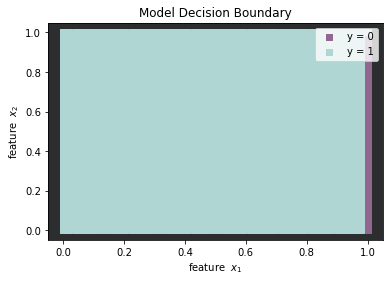

3/3 correctly classified (100.0%)


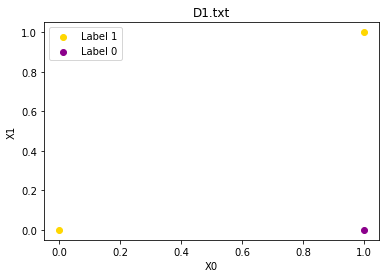

In [516]:
# create dataset
XY = np.array([[0,0,1],[1,1,1], [1,0,0]])

DTree = DecisionTee(XY, save_name="hand_vis", sort=True, grid_x_bounds = (1,0), grid_y_bounds = (1,0))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

plt.figure()
plt.scatter(XY[XY[:,2] == 1][:,0], XY[XY[:,2] == 1][:,1], color="gold", label = "Label 1")
plt.scatter(XY[XY[:,2] == 0][:,0], XY[XY[:,2] == 0][:,1], color="darkmagenta", label = "Label 0")
plt.xlabel("X0")
plt.ylabel("X1")
plt.title("D1.txt")
plt.legend()
plt.plot()
plt.savefig("hand_scatter.jpg")
[x0_df,x1_df] =DTree.getRootNodeState()
DTree.visualizeTree()

In [497]:
x0_df

,x0 >= c,Gain Ratio,Split Entropy,InfoGain
0,0.0,0.000000,0.000000,0.000000
1,1.0,0.274018,0.918296,0.251629


In [498]:
x1_df

,x1 >= c,Gain Ratio,Split Entropy,InfoGain
0,0.0,0.000000,0.000000,0.000000
1,1.0,0.274018,0.918296,0.251629


## Question 2.3

Number of Internal Nodes: 5
Number of Leaf Nodes: 6
Total Nodes: 11


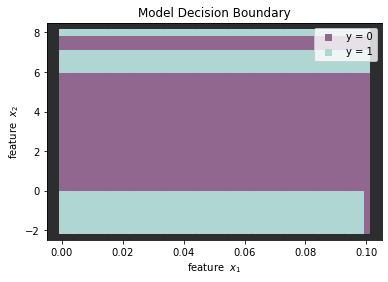

11/11 correctly classified (100.0%)


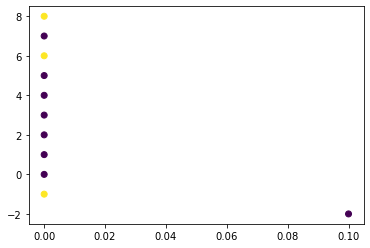

In [499]:
file = "Druns.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
DTree = DecisionTee(XY, save_name="druns_vis", sort=True, grid_x_bounds = (0.1,0), grid_y_bounds = (8,-2))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

plt.scatter(XY[:,0], XY[:,1], c = XY[:,2])
plt.plot()
[x0_df,x1_df] = DTree.getRootNodeState()
DTree.visualizeTree()

In [500]:
x0_df

,x0 >= c,Gain Ratio,Split Entropy,InfoGain
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.100518,0.439497,0.044177


In [501]:
x1_df

,x1 >= c,Gain Ratio,Split Entropy,InfoGain
0,0.0,0.055954,0.684038,0.038275
1,1.0,0.005780,0.845351,0.004886
2,2.0,0.001144,0.945660,0.001082
3,3.0,0.016411,0.994030,0.016313
4,4.0,0.049749,0.994030,0.049452
5,5.0,0.111240,0.945660,0.105196
6,6.0,0.236100,0.845351,0.199587
7,7.0,0.055954,0.684038,0.038275
8,8.0,0.430157,0.439497,0.189053
9,-1.0,0.100518,0.439497,0.044177


## Question 2.4

Number of Internal Nodes: 3
Number of Leaf Nodes: 4
Total Nodes: 7


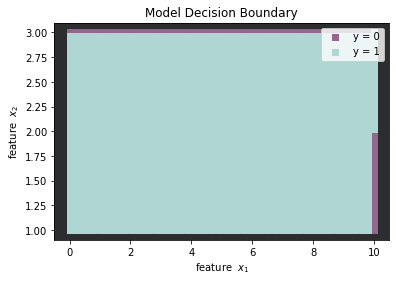

5/5 correctly classified (100.0%)


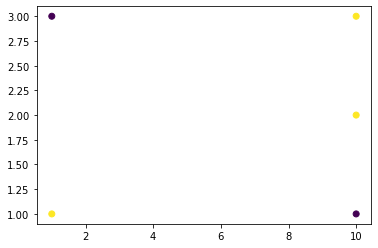

In [502]:
file = "D3leaves.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
XY[4,2] = 0
XY[3,2] = 1
XY[0,2] = 0
DTree = DecisionTee(XY, save_name="d3_vis", sort=True, grid_x_bounds=(10,0), grid_y_bounds=(3,1))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

[x0_df,x1_df] = DTree.getRootNodeState()

plt.scatter(XY[:,0], XY[:,1], c = XY[:,2])
plt.plot()
DTree.visualizeTree()

In [503]:
x0_df

,x0 >= c,Gain Ratio,Split Entropy,InfoGain
0,1.0,0.000000,0.000000,0.000000
1,10.0,0.020571,0.970951,0.019973


In [504]:
x1_df

,x1 >= c,Gain Ratio,Split Entropy,InfoGain
0,1.0,0.000000,0.000000,0.000000
1,2.0,0.020571,0.970951,0.019973
2,3.0,0.020571,0.970951,0.019973


## Question 2.5

Number of Internal Nodes: 1
Number of Leaf Nodes: 2
Total Nodes: 3


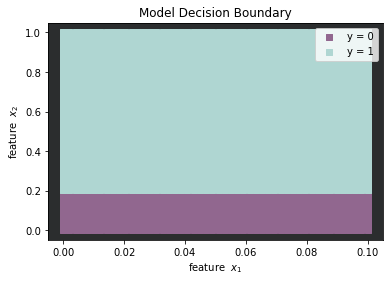

1000/1000 correctly classified (100.0%)


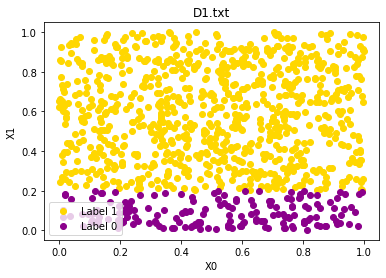

In [517]:
file = "D1.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
DTree = DecisionTee(XY, save_name="d1_vis", sort=True, grid_x_bounds = (0.1,0), grid_y_bounds = (1,0))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

plt.figure()
plt.scatter(XY[XY[:,2] == 1][:,0], XY[XY[:,2] == 1][:,1], color="gold", label = "Label 1")
plt.scatter(XY[XY[:,2] == 0][:,0], XY[XY[:,2] == 0][:,1], color="darkmagenta", label = "Label 0")
plt.xlabel("X0")
plt.ylabel("X1")
plt.title("D1.txt")
plt.legend()
plt.plot()
plt.savefig("d1_scatter.jpg")
[x0_df,x1_df] =DTree.getRootNodeState()
DTree.visualizeTree()

Number of Internal Nodes: 30
Number of Leaf Nodes: 31
Total Nodes: 61


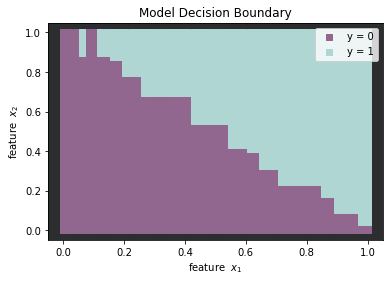

1000/1000 correctly classified (100.0%)


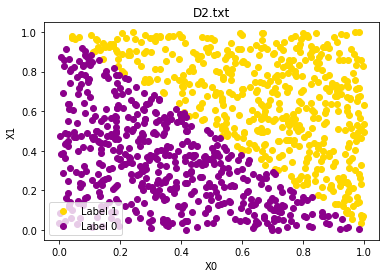

In [506]:
file = "D2.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
DTree = DecisionTee(XY, save_name="d2_vis", sort=True, grid_x_bounds = (1,0), grid_y_bounds = (1,0))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

plt.figure()
plt.scatter(XY[XY[:,2] == 1][:,0], XY[XY[:,2] == 1][:,1], color="gold", label = "Label 1")
plt.scatter(XY[XY[:,2] == 0][:,0], XY[XY[:,2] == 0][:,1], color="darkmagenta", label = "Label 0")
plt.xlabel("X0")
plt.ylabel("X1")
plt.title("D2.txt")
plt.legend()
plt.plot()
plt.savefig("d2_scatter.jpg")
DTree.visualizeTree()

Number of Internal Nodes: 151
Number of Leaf Nodes: 152
Total Nodes: 303


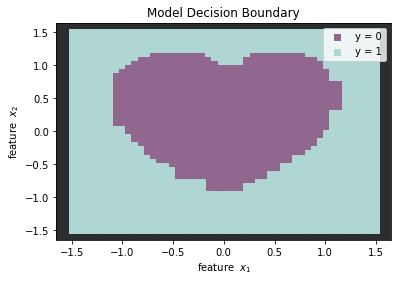

10000/10000 correctly classified (100.0%)


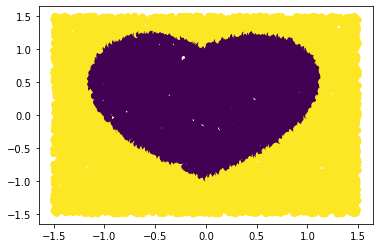

In [507]:
file = "Dbig.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
DTree = DecisionTee(XY, save_name="dbig_vis", sort=True, grid_x_bounds = (1.5,-1.5), grid_y_bounds = (1.5,-1.5))
#print(DTree)
# evaluate tree
X = XY[:,:2]
Y = XY[:,2]
Y_pred = DTree.predict(X)
correct_pred = np.sum(Y == Y_pred)
print(f"{correct_pred}/{len(X)} correctly classified ({correct_pred*100/len(X)}%)")

plt.scatter(XY[:,0], XY[:,1], c = XY[:,2])
plt.plot()

plt.scatter(XY[:,0], XY[:,1], c = XY[:,2])
plt.plot()
DTree.visualizeTree()

## Question 2.7

In [508]:
file = "Dbig.txt"
with open(file) as f:
    XY = np.array([[float(n) for n in f.split()] for f in f.readlines()])
np.random.shuffle(XY)
XY_train = XY[:8192,:]
XY_test = XY[8192:,:]
X_test = XY_test[:,[0,1]]
Y_test = XY_test[:,2]

In [509]:
XY_train_list = []
n_list = [32,128,512,2048,8192]
for n in n_list:
    XY_train_list.append(XY_train[:n,:])

Number of Internal Nodes: 4
Number of Leaf Nodes: 5
Total Nodes: 9


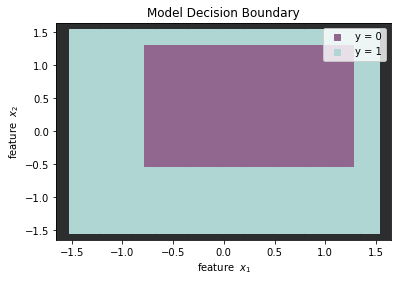

Number of Internal Nodes: 10
Number of Leaf Nodes: 11
Total Nodes: 21


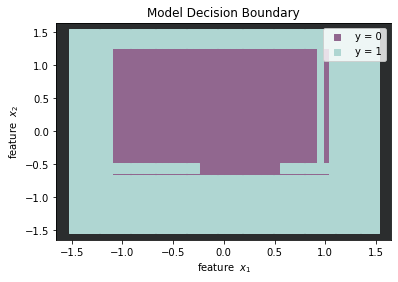

Number of Internal Nodes: 22
Number of Leaf Nodes: 23
Total Nodes: 45


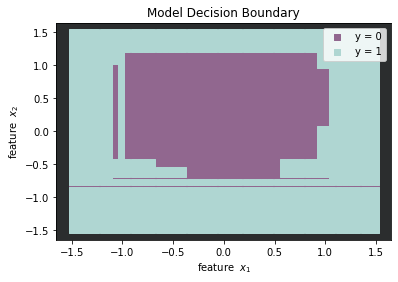

Number of Internal Nodes: 71
Number of Leaf Nodes: 72
Total Nodes: 143


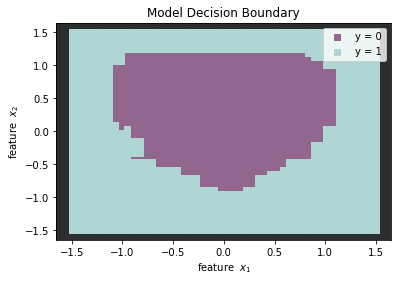

Number of Internal Nodes: 129
Number of Leaf Nodes: 130
Total Nodes: 259


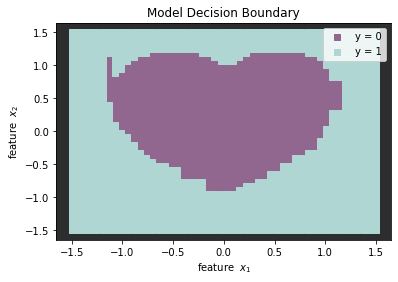

In [510]:
DTree_Models = []
err_vec = []
node_list = []
for i,XY_trn in enumerate(XY_train_list):
    dtree = DecisionTee(XY_trn, save_name="D"+str(n_list[i])+"_trn", sort=True, grid_x_bounds = (1.5,-1.5), grid_y_bounds = (1.5,-1.5))
    node_list.append(dtree.cnt_internal_nodes + dtree.cnt_internal_nodes)
    DTree_Models.append(dtree)
    # evaluate model
    Y_pred = dtree.predict(X_test)
    err = 1 - (np.sum(Y_test == Y_pred)/len(X_test))
    err_vec.append(err)

In [511]:
print(node_list)
print(n_list)
print(err_vec)

[8, 20, 44, 142, 258]
[32, 128, 512, 2048, 8192]
[0.15763274336283184, 0.07466814159292035, 0.0497787610619469, 0.028207964601769886, 0.015486725663716783]


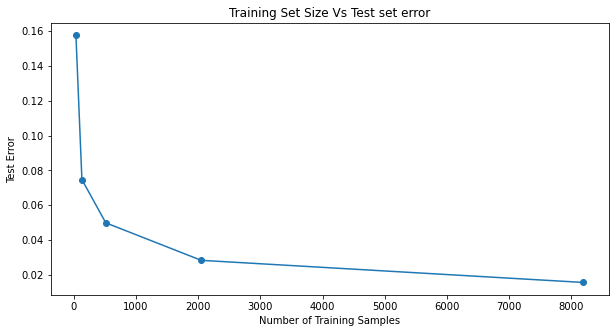

In [512]:
plt.figure(figsize=(10,5))
plt.plot(n_list, err_vec, "-o")
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Error")
plt.title("Training Set Size Vs Test set error")
plt.savefig("q27_nodes_v_err.jpg")

## Question 3

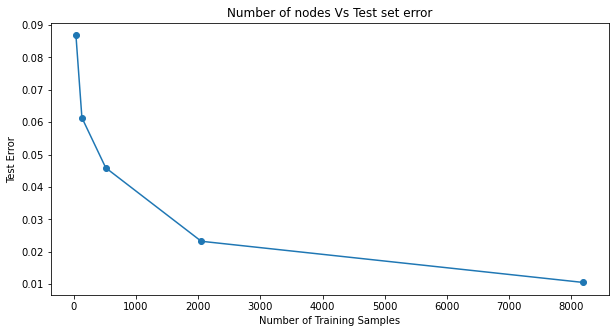

In [513]:
err_vec = []
node_list = []
for i,XY_trn in enumerate(XY_train_list):
    X_trn = XY_trn[:,[0,1]]
    Y_trn = XY_trn[:,2]
    clf = DecisionTreeClassifier(random_state=0).fit(X_trn,Y_trn)
    node_list.append(clf.tree_.node_count)
    Y_pred = clf.predict(X_test)
    # compute test err
    err = 1 - (np.sum(Y_test == Y_pred)/len(X_test))
    err_vec.append(err)

# plot
plt.figure(figsize=(10,5))
plt.plot(n_list, err_vec, "-o")
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Error")
plt.title("Number of nodes Vs Test set error")
plt.savefig("q3_nodes_v_err.jpg")

In [514]:
print(node_list)
print(err_vec)

[9, 19, 45, 133, 237]
[0.08683628318584069, 0.061393805309734484, 0.0459070796460177, 0.023230088495575174, 0.01050884955752207]


# Question 4

In [416]:
n = 100
a = 0
b = 1
x_trn = np.linspace(a,b,n)
y_trn = np.sin(x_trn)
m0 = lagrange(x_trn,y_trn)

trn_err = np.mean((m0(x_trn) - y_trn)**2)
print(f"Train Error: {trn_err}")

Train Error: 3.514037085856681e+138


In [417]:
x_tst = x_trn[:20]
y_tst = y_trn[:20]
tst_err = np.mean((m0(x_tst) - y_tst)**2)
print(f"Test Error: {tst_err}")

Test Error: 6.544951495008413e+64


In [418]:
std_list = [0.01, 0.1, 0.5, 1.0, 2.0, 5, 10, 15, 20]
tst_err_vec = []
trn_err_vec = []
for std in std_list:
    print(f"Adding Noise N(0,{std})")
    x_trn1 = x_trn + np.random.normal(0,std,n)
    y_trn1 = np.sin(x_trn1) # should you do this?
    m1 = lagrange(x_trn1,y_trn1)
    trn_err = np.log10(np.mean((m1(x_trn1) - y_trn1)**2))
    trn_err_vec.append(trn_err)
    print(f"Train Error: {trn_err}")
    
    tst_err = np.log10(np.mean((m1(x_tst) - y_tst)**2))
    tst_err_vec.append(tst_err)
    print(f"Test Error: {tst_err}\n")

Adding Noise N(0,0.01)
Train Error: 140.8023466988917
Test Error: 66.00095712223633

Adding Noise N(0,0.1)
Train Error: 160.68496027461774
Test Error: 82.19887439231826

Adding Noise N(0,0.5)
Train Error: 130.52233339569662
Test Error: 30.835070811446272

Adding Noise N(0,1.0)
Train Error: 126.29492299545804
Test Error: 8.834773964892294

Adding Noise N(0,2.0)
Train Error: 115.61216231096876
Test Error: -14.852259797556847

Adding Noise N(0,5)
Train Error: 112.04072131821516
Test Error: -28.078030444578445

Adding Noise N(0,10)
Train Error: 117.99296708010438
Test Error: -23.627552470259243

Adding Noise N(0,15)
Train Error: 115.90115974120917
Test Error: -24.150611790708467

Adding Noise N(0,20)
Train Error: 117.13912245373417
Test Error: -19.883967818030882



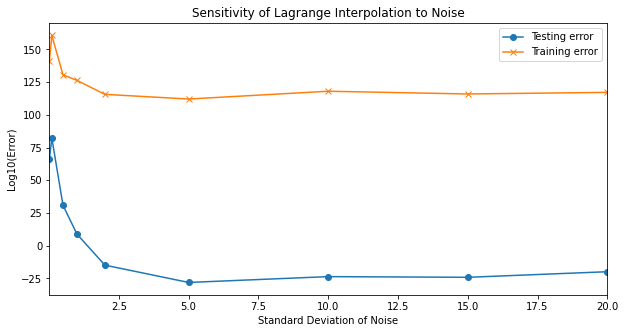

In [419]:
plt.figure(figsize=(10,5))
plt.plot(std_list,tst_err_vec, '-o', label="Testing error")
plt.plot(std_list, trn_err_vec, '-x', label="Training error")
plt.xlim(0.01,20)
plt.xlabel("Standard Deviation of Noise")
plt.ylabel("Log10(Error)")
plt.title("Sensitivity of Lagrange Interpolation to Noise")
plt.legend()
#plt.savefig("q4_err_plot.jpg")

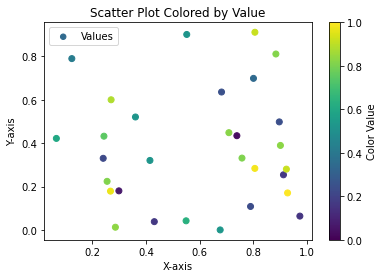

In [341]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data and colors
x = np.random.rand(30)
y = np.random.rand(30)
values = np.random.rand(30) * 10  # Sample values for coloring
colors = plt.cm.viridis(values / max(values))  # Normalize values and assign colors

# Create the scatter plot
plt.scatter(x, y, c=colors, label='Values')

# Add legend for the colors
legend = plt.legend()
legend.set_label('Color Legend')
legend.legendHandles[0].set_sizes([30])

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Color Value')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot Colored by Value')

# Show the plot
plt.show()
